# Generating synthetic sequences with embedded regulatory grammars for RNA-binding proteins

In this notebook, we will generate synthetic sequences with implanted regulatory grammars, i.e. set of motifs.  Each regulatory grammar is defined by a set of motifs that are separated in space a specific distance.  In this simple dataset, only a single regulatory grammar is embedded within each sequence, which basically means that there is no useless motifs implanted, i.e. only sampling noise from the position weight matrices.  In addition, the start position of the regulatory grammar can be implanted in random locations on the seuqence, albeit the spacing between the motifs are conserved.  Details of the simulation procedure is outlined below.

In [1]:
import os, sys, h5py
import numpy as np
import pandas as pd

# plotting tools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from deepomics import utils, visualize

np.random.seed(22) # for reproducibility

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Process JASPAR pfm and convert to pwm

First we need to download the JASPAR motifs:

! wget http://jaspar.genereg.net/html/DOWNLOAD/JASPAR_CORE/pfm/nonredundant/pfm_vertebrates.txt -O ../data/synthetic_TF_dataset/pfm_vertebrates.txt

If this doesn't work, then you can download it manually from the link and place it in the ../data/synthetic_TF_dataset directory.


Next, we need to load and parse the JASPAR motifs and generate a pool of core motifs for CTCF, GABPA, SP1, SRF, and YY1, and a generic pool of motifs from which we will randomly sample from.  

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


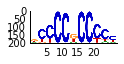

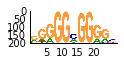

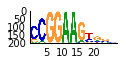

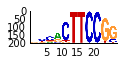

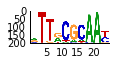

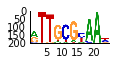

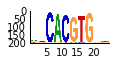

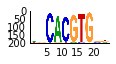

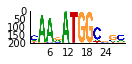

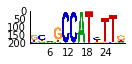

In [2]:
def get_jaspar_motifs(file_path):
    def get_motif(f):
        line = f.readline()
        name = line.strip().split()[1]
        pfm = []
        for i in range(4):
            line = f.readline()
            if len(line.split()[1]) > 1:
                pfm.append(np.asarray(np.hstack([line.split()[1][1:], line.split()[2:-1]]), dtype=float))
            else:
                pfm.append(np.asarray(line.split()[2:-1], dtype=float))
        pfm = np.vstack(pfm)
        sum_pfm = np.sum(pfm, axis=0)
        pwm = pfm/np.outer(np.ones(4), sum_pfm)
        line = f.readline()
        return name, pwm

    num_lines = sum(1 for line in open(file_path))
    num_motifs = int(num_lines/6)

    f = open(file_path)
    tf_names = []
    tf_motifs = []
    for i in range(num_motifs):
        name, pwm = get_motif(f)
        tf_names.append(name)
        tf_motifs.append(pwm)

    return tf_motifs, tf_names

# parse JASPAR motifs
savepath = '../data'
file_path = os.path.join(savepath, 'pfm_vertebrates.txt')
motif_set, motif_names = get_jaspar_motifs(file_path)

# get a subset of core motifs 
core_names = ['SP1', 'Gabpa', 'CEBPB', 'MAX', 'YY1']
strand_motifs = []
core_index = []
for name in core_names:
    index = motif_names.index(name)
    strand_motifs.append(motif_set[index])
    core_index.append(index)

# generate reverse compliments
core_motifs = []
for pwm in strand_motifs:
    core_motifs.append(pwm)
    reverse = pwm[:,::-1]
    core_motifs.append(reverse[::-1,:]) 
    
# visualize core motifs
for pwm in core_motifs:
    logo = visualize.seq_logo(pwm, height=100, nt_width=50, norm=0, alphabet='dna')
    fig = plt.figure(figsize = (5,1))
    visualize.plot_seq_logo(logo, nt_width=20, step_multiple=4)

In [3]:
len(core_motifs)

10

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


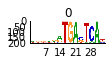

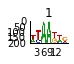

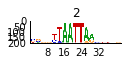

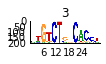

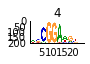

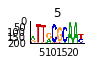

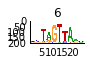

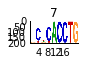

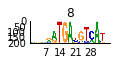

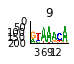

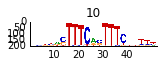

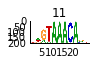

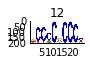

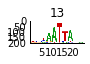

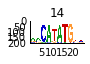

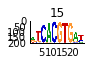

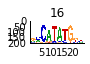

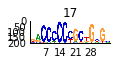

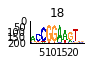

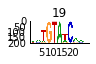

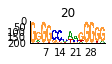

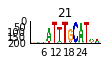

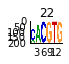

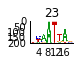

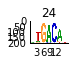

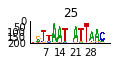

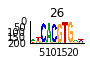

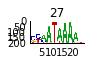

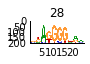

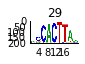

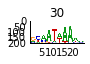

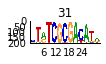

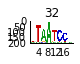

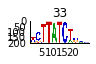

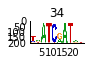

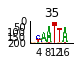

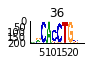

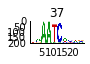

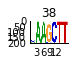

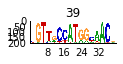

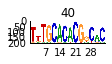

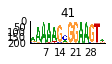

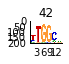

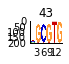

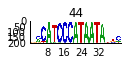

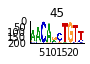

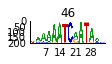

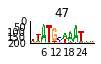

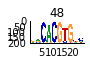

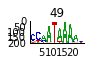

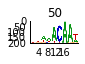

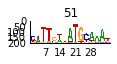

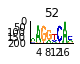

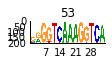

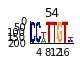

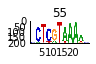

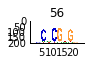

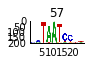

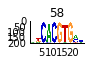

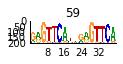

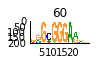

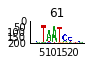

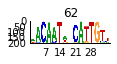

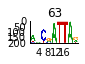

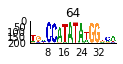

In [4]:
# randomly select background sequences which include core motifs
num_background = 65        
motif_index = np.random.permutation(len(motif_set))[0:num_background]
motif_index = motif_index
background_motifs = []
for index in motif_index:
    pwm = motif_set[index]
    background_motifs.append(pwm)  
    
# visualize background motifs
for i, pwm in enumerate(background_motifs):
    logo = visualize.seq_logo(pwm, height=100, nt_width=50, norm=0, alphabet='dna')
    fig = plt.figure(figsize = (5,1))
    visualize.plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.title(i)

### Filter background motifs that look like core motifs

In [5]:
duplicate_index = [4, 5, 12, 15, 17, 18, 20, 36, 42, 60]
motif_index = set(motif_index) - set(duplicate_index)

# randomly select background sequences which include core motifs
background_motifs = []
for motif in core_motifs:
    background_motifs.append(motif)
    
for index in list(motif_index)[:50]:
    pwm = motif_set[index]
    background_motifs.append(pwm)  
    reverse = pwm[:,::-1]
    background_motifs.append(reverse[::-1,:]) 

# Simulation overview


We define a regulatory grammar, $G$, as a the interactions of specific motifs spaced in specific spatial positions. Each grammar consists of a position weight matrix (PWM) with implanted motifs from which a synthetic sequence is generated from.  In this synthetic dataset, each simulated sequence is generated from a given grammar that is randomly translated, but the motifs and spatial positions between motifs within the grammar are conserved. 

To generate each regulatory grammar, we first create a model which consists of a subset of motifs and their spatial distances with respect to one another. We limit the pool of possible motifs to $M$ motifs to include all of the core motifs and a subset of motifs (num_motif total motifs) which are randomly sampled from the pool of JASPAR database (under the list tf_motifs).  For a given grammar, the number of motifs is determined by sampling an exponential distribution (parameterized by interaction_rate).  Then, the minimum is taken between this value and the max_motif, which imposes the constraint of a maximum number of motifs for a given grammar.  

The motifs are randomly sampled from the pool of available motifs and the distance between each motif is determined by randomly sampling an exponential distribution (parameterized by distance_scale) plus a minimum distance between motifs (distance_offset). The motifs are placed along a PWM in locations determined by the distances between motifs. For simplicity, we will use a uniform distribution for the PWMs for all 'non-motif' nucleotides, i.e. $p = 1/4$.
This constitutes the regulatory grammar model, from which synthetic sequences can be simulated from.  Moreover, each regulatory grammar is associated to a given class.


Note that here we elect not to include alternative regulatory codes for a given class directly.  Since we are sampling from a smaller pool, we assume alternative codes will give rise to a different phenotype, specified by a different class.   Also, we do not alter the spacing between the motifs or include noisy motifs in the grammar model.  All of the noise comes from random sampling in generating the sequence and the translation of the grammar.  



In [6]:
def generate_model(core_motifs, min_interactions, max_interactions, seq_length):
    
    num_motif = len(core_motifs)
    cum_dist = np.cumsum([0, 0, 0.5, 0.25, 0.17, .05, 0.3])
    
    # sample core motifs for each grammar
    valid_sim = False
    while not valid_sim:

        # determine number of core motifs in a given grammar model
        num_interactions = np.where(np.random.rand() > cum_dist)[0][-1]+2 #np.random.randint(min_interactions, max_interactions)

        # randomly sample motifs
        sim_motifs = np.random.randint(num_motif, size=num_interactions)
        num_sim_motifs = len(sim_motifs)
        #sim_motifs = sim_motifs[np.random.permutation(num_sim_motifs)]
        
        # verify that distances aresmaller than sequence length
        distance = 0
        for i in range(num_sim_motifs):
            distance += core_motifs[sim_motifs[i]].shape[1]
        if seq_length > distance > 0:
            valid_sim = True    

    # simulate distances between motifs + start 
    valid_dist = False
    while not valid_dist:
        remainder = seq_length - distance
        sep = np.random.uniform(0, 2, size=num_sim_motifs+1)
        sep = np.round(sep/sum(sep)*remainder).astype(int)
        if np.sum(sep) == remainder:
            valid_dist = True

    # build a PWM for each regulatory grammar
    pwm = np.ones((4,sep[0]))/4
    for i in range(num_sim_motifs):
        pwm = np.hstack([pwm, core_motifs[sim_motifs[i]], np.ones((4,sep[i+1]))/4])

    return pwm


def simulate_sequence(sequence_pwm):
    """simulate a sequence given a sequence model"""

    nucleotide = 'ACGT'

    # sequence length
    seq_length = sequence_pwm.shape[1]

    # generate uniform random number for each nucleotide in sequence
    Z = np.random.uniform(0,1,seq_length)

    # calculate cumulative sum of the probabilities
    cum_prob = sequence_pwm.cumsum(axis=0)

    # go through sequence and find bin where random number falls in cumulative 
    # probabilities for each nucleotide
    one_hot_seq = np.zeros((4, seq_length))
    for i in range(seq_length):
        index=[j for j in range(4) if Z[i] < cum_prob[j,i]][0]
        one_hot_seq[index,i] = 1
    return one_hot_seq


In [36]:
seq_length = 200           # length of sequence
min_interactions = 3       # exponential rate of number of motifs for each grammar
max_interactions = 6
num_plot =  5             # number of regulatory grammars
save_path = '../results'
# sample the motifs and distance between each motif for each grammar
seq_model = []
for j in range(num_plot):    
    pwm = generate_model(core_motifs, min_interactions, max_interactions, seq_length)

    logo = visualize.seq_logo(pwm, height=50, nt_width=20, norm=0, alphabet='dna')
    fig = plt.figure(figsize = (20,1.25))
    visualize.plot_seq_logo(logo, nt_width=20, step_multiple=4)   
    plt.axis('off')
    plt.axis('tight')
    #outfile = os.path.join(save_path, 'saliency_'+str(j)+'.pdf')
    #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    #plt.close()
    
    fig = plt.figure(figsize = (20,1.5))
    plt.imshow(pwm, cmap='bwr', interpolation='none')
    plt.yticks([0, 1, 2, 3], ['A', 'C','G','T'])
    plt.xticks([0, 50,100,150,200])
    plt.axis('tight')
    #outfile = os.path.join(save_path, 'matrix_'+str(j)+'.pdf')
    #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    #plt.close()
    
    #plt.title('model ' + str(i), fontsize=10)


# Simulation overview

The number of sequences for each grammar is determined by a randomly sampled population fraction (pop_fraction).  For a each grammar model, the total number of sequences simulated is then, $N$ times its population fraction. For each sequence, the grammar model is randomly translated according to a Gaussian distribution, but with constraints to make sure the entire grammar is contained within the sequence.  Then, the cumulative sum at each nucleotide position of the translated model is calculated.  A uniform random number from 0 to 1 is generated and the bin with which it falls with respect to the the cumulative proprabilities specifies the simulated nucleotide value.  THis is done for each nucleotide position to simulate the entire sequence of length $S$. 

After all of the the synthetic sequences are generated, i.e. the sequence model (translated grammar), and an indicator vector of length $G$ specifying which grammar generated the sequence, the dataset is split into training, cross-validation, and a test set.  Then each dataset is stored in a hdf5 file.  


In [9]:
# dataset parameters
num_seq = 10000             # number of sequences
seq_length = 200            # length of sequence
min_interactions = 3        # exponential rate of number of motifs for each grammar
max_interactions = 6
# generate sythetic sequences as a one-hot representation
seq_pwm = []
seq_model = []    
num_sim = int(num_seq/2)
for j in range(num_sim):
    signal_pwm = generate_model(core_motifs, min_interactions, max_interactions, seq_length)
    seq_pwm.append(simulate_sequence(signal_pwm))
    seq_model.append(signal_pwm)

# simulate a background sequence
for j in range(num_sim):
    background_pwm = generate_model(background_motifs, 2, max_interactions, seq_length)
    seq_pwm.append(simulate_sequence(background_pwm))
    seq_model.append(background_pwm)
    
# generate labels
seq_label = np.vstack([np.ones((num_sim,1)), np.zeros((num_sim, 1))])


In [10]:
def split_data(data, label, model, split_size):
    """split data into train set, cross-validation set, and test set"""
    
    def subset_data(data, label, model, sub_index):
        """returns a subset of the data and labels based on sub_index"""
        
        num_sub = len(sub_index)
        sub_set_label = []
        sub_set_seq = []
        sub_set_model = []
        for index in sub_index:
            sub_set_seq.append([data[index]])
            sub_set_label.append(label[index])
            sub_set_model.append([model[index]])
        sub_set_seq = np.vstack(sub_set_seq)
        sub_set_label = np.vstack(sub_set_label)
        sub_set_model = np.vstack(sub_set_model)
    
        return (sub_set_seq, sub_set_label, sub_set_model)

    
    # determine indices of each dataset
    N = len(data)
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],N)).astype(int) 

    # shuffle data
    shuffle = np.random.permutation(N)

    # training dataset
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    cross_validation_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    print('Generating training data')
    train = subset_data(data, label, model, train_index)

    print('Generating cross-validation data')
    cross_validation = subset_data(data, label, model, cross_validation_index)
    
    print('Generating test data')    
    test = subset_data(data, label, model, test_index)
    
    return train, cross_validation, test


def save_dataset(savepath, train, valid, test):
    f = h5py.File(savepath, "w")
    dset = f.create_dataset("X_train", data=train[0], compression="gzip")
    dset = f.create_dataset("Y_train", data=train[1], compression="gzip")
    dset = f.create_dataset("model_train", data=train[2], compression="gzip")
    dset = f.create_dataset("X_valid", data=valid[0], compression="gzip")
    dset = f.create_dataset("Y_valid", data=valid[1], compression="gzip")
    dset = f.create_dataset("model_valid", data=valid[2], compression="gzip")
    dset = f.create_dataset("X_test", data=test[0], compression="gzip")
    dset = f.create_dataset("Y_test", data=test[1], compression="gzip")
    dset = f.create_dataset("model_test", data=test[2], compression="gzip")
    f.close()
    
    
# split into training, cross-validation, and test sets
print("Splitting dataset into train, cross-validation, and test")
train_size = 0.7
cross_validation_size = 0.1
test_size = 0.2
split_size = [train_size, cross_validation_size, test_size]
train, valid, test = split_data(seq_pwm, seq_label, seq_model, split_size)

# save to file
filename =  'Synthetic_dataset.h5' 
file_path = os.path.join(savepath, filename)
print('Saving to: ' + file_path)
save_dataset(file_path, train, valid, test)

Splitting dataset into train, cross-validation, and test
Generating training data
Generating cross-validation data
Generating test data
Saving to: ../data/Synthetic_dataset.h5
